# 모델학습

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from pymongo import MongoClient
import time
import pickle
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import threading
import os
import pandas as pd
import pymongo as mg
import datetime
import keras
from time import sleep
from tensorflow import feature_column
import psycopg2
from datetime import datetime, timedelta
from numpy import dot
from numpy.linalg import norm
import psutil

In [4]:
df = pd.read_csv("bonc_pcs_202203020936.csv")
# data=df[:45440]

In [5]:
df

,pcs_status,output_power,output_voltage,output_currrent,grid_power,grid_voltage,grid_charge_current,pv_power,pv_voltage,pv_current,pv_frequency,battery_voltage,mppt_charge_current,inverter_temp,d_time
0,운전,0.0,219.0,0.0,0.0,1.0,0.0,6.48,64.8,0.1,60.0,52.6,0.3,8.0,2022-03-02 09:29:46
1,운전,0.0,221.0,0.0,0.0,1.0,0.0,6.66,66.6,0.1,60.0,52.6,0.2,8.0,2022-03-02 09:29:46
2,운전,0.0,218.0,0.0,0.0,1.0,0.0,6.75,67.5,0.1,60.0,52.6,0.3,8.0,2022-03-02 09:29:45
3,운전,0.0,221.0,0.0,0.0,1.0,0.0,6.82,68.2,0.1,60.0,52.6,0.3,8.0,2022-03-02 09:29:44
4,운전,0.0,218.0,0.0,0.0,1.0,0.0,6.84,68.4,0.1,60.0,52.6,0.3,8.0,2022-03-02 09:29:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96843,정지,0.0,1.0,0.0,0.0,1.0,0.0,5.44,54.4,0.1,60.0,53.4,0.3,29.0,2020-07-25 17:37:56
96844,정지,0.0,1.0,0.0,0.0,1.0,0.0,5.45,54.5,0.1,60.0,53.4,0.3,29.0,2020-07-25 17:37:54
96845,정지,0.0,1.0,0.0,0.0,1.0,0.0,5.44,54.4,0.1,60.0,53.3,0.3,29.0,2020-07-25 17:37:52
96846,정지,0.0,1.0,0.0,0.0,1.0,0.0,5.44,54.4,0.1,60.0,53.3,0.3,29.0,2020-07-25 17:37:50


In [6]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

def baseline(history):
    return np.mean(history)

uni_data = df['pv_power']
uni_data.index = df['d_time']
uni_data = uni_data.values
uni_train_mean = uni_data[:].mean()
uni_train_std = uni_data[:].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

x_train_uni, y_train_uni = univariate_data(uni_data, 0, 80000,24,0)
x_val_uni, y_val_uni = univariate_data(uni_data, 80000, 96000,24,0)
x_test_uni, y_test_uni = univariate_data(uni_data, 96000, None,24,0)

BATCH_SIZE = 256
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.fit(train_univariate, epochs=40, steps_per_epoch=200, validation_data=val_univariate, validation_steps=200)

Epoch 1/40
200/200 [==============================] - 4s 13ms/step - loss: 0.4173 - val_loss: 0.1282

# 성능평가 및 저장

<ipython-input-1-741e9d92f82e>:54: RuntimeWarning: invalid value encountered in true_divide
  t_data = (t_data-uni_train_mean)/uni_train_std


ValueError: x and y must have same first dimension, but have shapes (90,) and (89,)

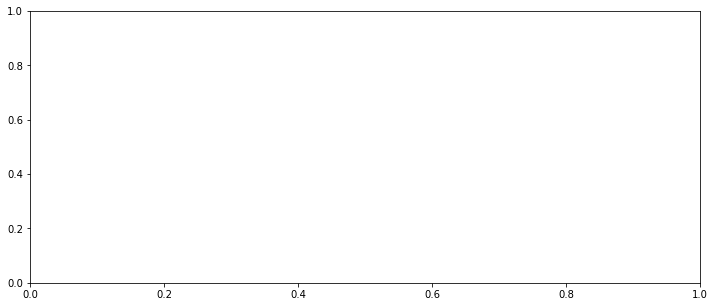

<ipython-input-1-741e9d92f82e>:54: RuntimeWarning: invalid value encountered in true_divide
  t_data = (t_data-uni_train_mean)/uni_train_std


In [20]:
look_ahead = 90
pred=[]
xhat = x_test_uni
for i in range(look_ahead):
    prediction = simple_lstm_model.predict(x_test_uni[i].reshape(1,24,1), batch_size=32)
    pred.append(prediction[0][0])
    
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),pred[1:],'r',label="prediction")
plt.plot(np.arange(look_ahead),y_test_uni[:look_ahead-1],label="test function")
plt.legend()
plt.show()

In [ ]:
simple_lstm_model.save('model_smartfarm.h5')

# 실시간 데이터에 대한 예측값 도출 메서드

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from pymongo import MongoClient
import time
import pickle
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import threading
import os
import pandas as pd
import pymongo as mg
import datetime
import keras
from time import sleep
from tensorflow import feature_column
import psycopg2
from datetime import datetime, timedelta
from numpy import dot
from numpy.linalg import norm
import psutil

def auto():
    while(True):
        D_new = []
        D_all = []
        D_data = []
        model1 = tf.keras.models.load_model('./model_smartfarm.h5')
        connection = mg.MongoClient("192.168.0.54", 27017)
        db = connection.air
        collection = db.SmartFarm_PV
        collection2 = db.SmartFarm_PV_pre
        new_data = collection.find().sort("_id", -1)[1:2]
        day_data = collection.find().sort("_id", -1)[1:25]
        for i in new_data:
            D=[]
            D.append(i['d_time'])
            D.append(float(i['pv_power']))
            D_new.append(D)
        for i in day_data:
            D=[]
            D.append(i['d_time'])
            D.append(float(i['pv_power']))
            D_all.append(D)
            D_data.append(float(i['pv_power']))

        dic = {"Power": D_data}
        df_set = pd.DataFrame(dic)

        t_data = df_set['Power']
        t_data = t_data.values
        uni_train_mean = t_data[:].mean()
        uni_train_std = t_data[:].std()
        t_data = (t_data-uni_train_mean)/uni_train_std
        data = []
        data.append(np.reshape(t_data[0:24], (24, 1)))
        Input = np.array(data)
        
        if uni_train_std==0:
            predict=uni_train_mean
        else:
            predict=float(model1.predict(Input)[0][0]*uni_train_std+uni_train_mean)
        
        now = datetime.now()
        Current_time = "{}-{}-{} {}:{}:{}".format(now.strftime("%Y"), now.strftime("%m"), now.strftime("%d"), now.strftime("%H"), now.strftime("%M"), now.strftime("%S"))         
        doc = {'Prediction_TIME':Current_time,'History':D_all,
               'True': D_new[0][1],'Prediction': predict,
               'LossRate':abs(round(((D_new[0][1]-predict)/D_new[0][1]*100), 3)) 
              }
        collection2.insert_one(doc)
        time.sleep(10)
        
t1 = threading.Thread(target = auto)
t1.start()

<ipython-input-1-741e9d92f82e>:54: RuntimeWarning: invalid value encountered in true_divide
  t_data = (t_data-uni_train_mean)/uni_train_std
<ipython-input-1-741e9d92f82e>:68: RuntimeWarning: invalid value encountered in double_scalars
  'LossRate':abs(round(((D_new[0][1]-predict)/D_new[0][1]*100), 3))
